**Import Libraries and Check for GPU**

In [1]:
# Import required libraries
import os
import zipfile
import torch
import random
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Check for CUDA (GPU) availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Download and Extract Dataset (Tiny ImageNet)**

In [2]:
# Download and unzip Tiny ImageNet dataset if it does not exist
if not os.path.exists("tiny-imagenet-200"):
    !wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
    with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
        zip_ref.extractall()
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")


Dataset downloaded and extracted.


**Load Dataset and Apply Transformations**

In [3]:
# Define image transformation (convert to tensor and normalize)
transform = transforms.Compose([transforms.ToTensor()])

# Load train dataset
train_dir = "tiny-imagenet-200/train"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Load validation dataset manually (Tiny ImageNet val folder lacks subfolders)
val_dir = "tiny-imagenet-200/val/images"
val_images = glob.glob(os.path.join(val_dir, "*.JPEG"))

# Define custom validation dataset class
class ValDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img

# Create validation dataset
val_dataset = ValDataset(val_images, transform=transform)


**Create DataLoader for Training and Validation**

In [4]:
# Custom dataset to return (cover, secret) image pairs
class StegoPairs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    def __len__(self):
        return len(self.base_dataset)
    def __getitem__(self, idx):
        cover_img, _ = self.base_dataset[idx]
        secret_idx = random.randint(0, len(self.base_dataset)-1)
        if secret_idx == idx:
            secret_idx = (secret_idx + 1) % len(self.base_dataset)
        secret_img, _ = self.base_dataset[secret_idx]
        return cover_img, secret_img

# Create datasets and DataLoaders
train_pairs = StegoPairs(train_dataset)
val_pairs = StegoPairs(val_dataset)

train_loader = DataLoader(train_pairs, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_pairs, batch_size=32, shuffle=False, pin_memory=True)


**Define Generator, Discriminator, and Extractor Models**

In [5]:
# Generator Model
class SteganoGenerator(nn.Module):
    def __init__(self):
        super(SteganoGenerator, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        stego = torch.sigmoid(self.conv3(x))
        return stego
# Discriminator Model
class SteganoDiscriminator(nn.Module):
    def __init__(self):
        super(SteganoDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(8*8*64, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, img):
        x = F.leaky_relu(self.conv1(img), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        return self.fc2(x)
# Extractor Model
class SteganoExtractor(nn.Module):
    def __init__(self):
        super(SteganoExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    def forward(self, stego):
        x = F.relu(self.conv1(stego))
        x = F.relu(self.conv2(x))
        return torch.sigmoid(self.conv3(x))
# Instantiate models
generator = SteganoGenerator().to(device)
discriminator = SteganoDiscriminator().to(device)
extractor = SteganoExtractor().to(device)

# Define Optimizers
opt_D = optim.Adam(discriminator.parameters(), lr=1e-4)
opt_GE = optim.Adam(list(generator.parameters()) + list(extractor.parameters()), lr=1e-4)

# Define Loss Functions
bce_loss = nn.BCEWithLogitsLoss()
mse_loss = nn.MSELoss()


**Train GAN Model (Generator, Discriminator, and Extractor)**

In [6]:
# Training Loop
for epoch in range(20):
    total_loss_D, total_loss_GE = 0.0, 0.0
    for covers, secrets in train_loader:
        covers, secrets = covers.to(device, non_blocking=True), secrets.to(device, non_blocking=True)
        batch_size = covers.size(0)

        # Train Discriminator
        opt_D.zero_grad()
        with torch.no_grad():
            stegos = generator(covers, secrets)
        real_pred = discriminator(covers)
        fake_pred = discriminator(stegos)
        real_targets, fake_targets = torch.ones(batch_size, 1, device=device), torch.zeros(batch_size, 1, device=device)
        loss_D = bce_loss(real_pred, real_targets) + bce_loss(fake_pred, fake_targets)
        loss_D.backward()
        opt_D.step()
        total_loss_D += loss_D.item()

        # Train Generator + Extractor
        opt_GE.zero_grad()
        stegos = generator(covers, secrets)
        pred_stego = discriminator(stegos)
        recovered = extractor(stegos)
        loss_GE = 0.1 * bce_loss(pred_stego, real_targets) + mse_loss(stegos, covers) + mse_loss(recovered, secrets)
        loss_GE.backward()
        opt_GE.step()
        total_loss_GE += loss_GE.item()

    print(f"Epoch [{epoch+1}/20] - Loss_D: {total_loss_D:.4f}, Loss_GE: {total_loss_GE:.4f}")

torch.cuda.empty_cache()
print("Training complete. GPU memory optimized.")


Epoch [1/20] - Loss_D: 4207.5310, Loss_GE: 366.0409
Epoch [2/20] - Loss_D: 4178.3742, Loss_GE: 310.8078
Epoch [3/20] - Loss_D: 4169.9954, Loss_GE: 304.5361
Epoch [4/20] - Loss_D: 4185.7274, Loss_GE: 296.4755
Epoch [5/20] - Loss_D: 4188.0608, Loss_GE: 288.4887
Epoch [6/20] - Loss_D: 4177.4193, Loss_GE: 287.9877
Epoch [7/20] - Loss_D: 4162.1385, Loss_GE: 288.9910
Epoch [8/20] - Loss_D: 4145.1043, Loss_GE: 290.9607
Epoch [9/20] - Loss_D: 4151.6028, Loss_GE: 292.3424
Epoch [10/20] - Loss_D: 4144.0060, Loss_GE: 293.9868
Epoch [11/20] - Loss_D: 4150.0755, Loss_GE: 288.3130
Epoch [12/20] - Loss_D: 4136.6215, Loss_GE: 294.2209
Epoch [13/20] - Loss_D: 4114.2410, Loss_GE: 293.6396
Epoch [14/20] - Loss_D: 4101.5173, Loss_GE: 296.9910
Epoch [15/20] - Loss_D: 4061.8097, Loss_GE: 304.2746
Epoch [16/20] - Loss_D: 4079.0073, Loss_GE: 303.2536
Epoch [17/20] - Loss_D: 4057.8300, Loss_GE: 304.6512
Epoch [18/20] - Loss_D: 4048.9845, Loss_GE: 306.2217
Epoch [19/20] - Loss_D: 4037.2125, Loss_GE: 312.3410
Ep

**Visualizing the Results (Cover, Secret, Stego, and Extracted Images)**

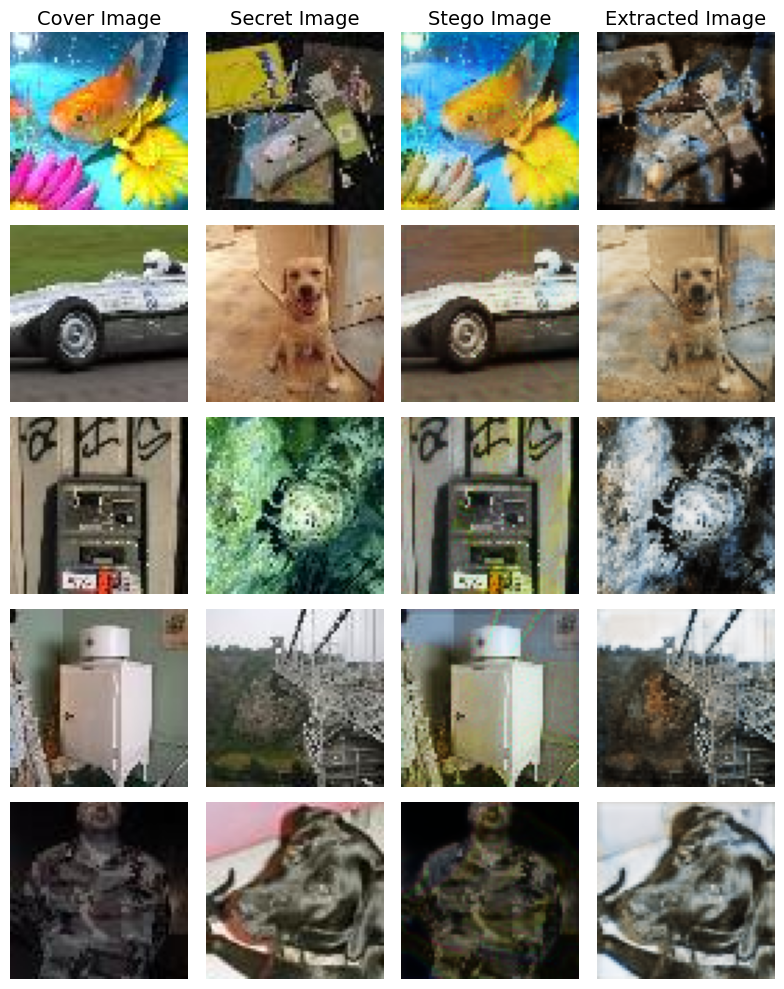

In [15]:
import matplotlib.pyplot as plt

# Set models to evaluation mode
generator.eval()
extractor.eval()

# Get 5 sample pairs from the validation dataset
samples = []
for i in range(5):
    cover_idx = random.randint(0, len(val_dataset) - 1)
    secret_idx = random.randint(0, len(val_dataset) - 1)
    while secret_idx == cover_idx:  # Ensure they are different images
        secret_idx = random.randint(0, len(val_dataset) - 1)

    cover = val_dataset[cover_idx].unsqueeze(0).to(device)
    secret = val_dataset[secret_idx].unsqueeze(0).to(device)

    samples.append((cover, secret))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 10))

for i, (cover, secret) in enumerate(samples):
    with torch.no_grad():
        stego = generator(cover, secret)  # Generate stego image
        extracted = extractor(stego)  # Extract secret image

    # Convert tensors to images
    def tensor_to_image(tensor):
        img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        return img

    images = [
        tensor_to_image(cover),
        tensor_to_image(secret),
        tensor_to_image(stego),
        tensor_to_image(extracted)
    ]

    # Display images in the table
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

    # Add row labels
    axes[i, 0].set_ylabel(f"Example {i+1}", fontsize=12)

# Add column headers
axes[0, 0].set_title("Cover Image", fontsize=14)
axes[0, 1].set_title("Secret Image", fontsize=14)
axes[0, 2].set_title("Stego Image", fontsize=14)
axes[0, 3].set_title("Extracted Image", fontsize=14)

plt.tight_layout()
plt.show()
